In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 193
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=100

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3

DATASET_DIR_NAME = "dataset\set03\\02_pair_rand"
SAMPLE_DATASET_NAME = "pair_train_rand"
ACTUAL_DATASET_NAME = "pair_test_rand"

MODEL_DIR_NAME = "dataset\set03\\02_pair_rand"
MODEL_NAME = "model_" + "set03_02_pair_rand"

RESULT_DIR_NAME = "dataset\set03\\02_pair_rand"
RESULT_NAME = "result_" + "set03_02_pair_rand"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\02_pair_rand
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\02_pair_rand
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\02_pair_rand\pair_train_rand.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T4-RF|VAR.1,T4-NG|VAR.1,T4-I|SD.1,T4-PF|SD.1,T4-RF|SD.1,T4-NG|SD.1,T5-I|0+4.1,T5-PF|0+4.1,T5-RF|0+4.1,T5-NG|0+4.1
0,adhy,apish,0.176624,-0.081235,0.095389,0.054188,0.230811,0.135423,-0.079058,0.056365,...,0.018428,0.010549,0.106929,0.073887,0.135748,0.102706,0.568097,0.688471,0.671329,0.791703
1,adhy,apish,0.176624,-0.081235,0.095389,0.054188,0.230811,0.135423,-0.079058,0.056365,...,0.009239,0.002546,0.056287,0.010623,0.096118,0.050453,0.328402,0.431805,0.384529,0.487932
2,adhy,apish,0.176624,-0.081235,0.095389,0.054188,0.230811,0.135423,-0.079058,0.056365,...,0.004547,0.004534,0.078745,0.078653,0.067429,0.067337,0.519806,0.615577,0.648569,0.744340
3,adhy,apish,0.176624,-0.081235,0.095389,0.054188,0.230811,0.135423,-0.079058,0.056365,...,0.012902,0.014318,0.045071,0.051139,0.113588,0.119657,0.448259,0.561053,0.519647,0.632440
4,adhy,apish,0.176624,-0.081235,0.095389,0.054188,0.230811,0.135423,-0.079058,0.056365,...,0.000880,0.000853,0.011580,0.011127,0.029663,0.029210,0.215585,0.335845,0.319089,0.439348


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


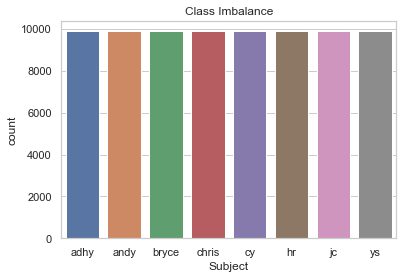

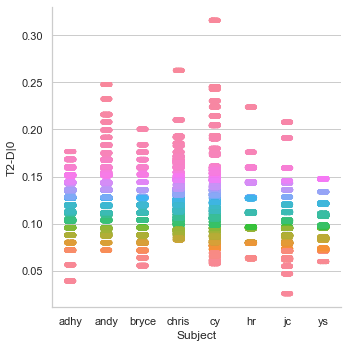

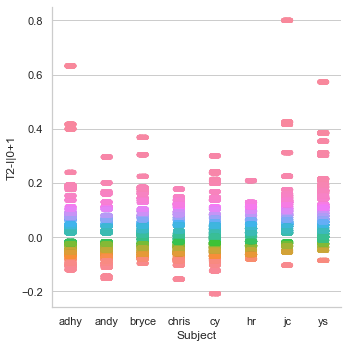

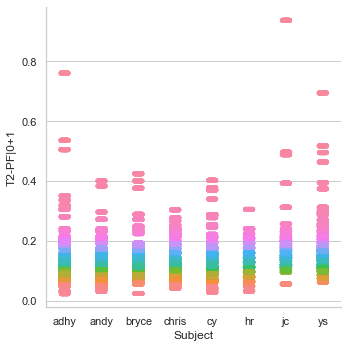

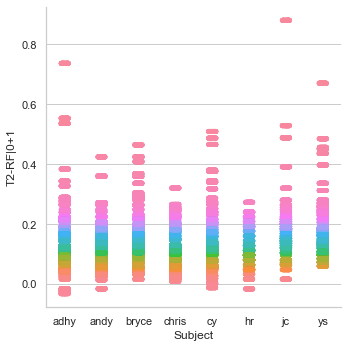

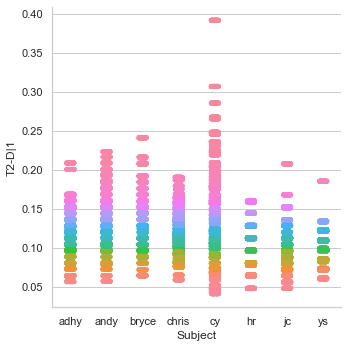

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['adhy' 'andy' 'bryce' 'chris' 'cy' 'hr' 'jc' 'ys']


X | Features | Dataset Shape: (79200, 193)
Y | Classes  | Dataset Shape: (79200, 8)
Number of Classes: 8


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (63360, 1, 193)
Y train shape: (63360, 8)
X test shape: (15840, 1, 193)
Y test shape: (15840, 8)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 8 classes.
Epoch 1/200
507/507 [==============================] - 15s 17ms/step - loss: 1.8129 - accuracy: 0.2507
Epoch 2/200
507/507 [==============================] - 8s 15ms/step - loss: 1.4912 - accuracy: 0.3767
Epoch 3/200
507/507 [==============================] - 7s 15ms/step - loss: 1.4047 - accuracy: 0.4355
Epoch 4/200
507/507 [==============================] - 7s 15ms/step - loss: 1.3515 - accuracy: 0.4693
Epoch 5/200
507/507 [==============================] - 8s 15ms/step - loss: 1.2961 - accuracy: 0.4985
Epoch 6/200
507/507 [==============================] - 8s 15ms/step - loss: 1.2540 - accuracy: 0.5130
Epoch 7/200
507/507 [==============================] - 8s 15ms/step - loss: 1.2144 - accuracy: 0.5334
Epoch 8/200
507/507 [==============================] - 8s 15ms/step - loss: 1.1709 - accuracy: 0.5548
Epoch 9/200
507/507 [==============================] - 8s 15ms/step - loss: 1.1320 - accuracy: 0.5798
Epoch 10/200
507/507 [===========================

507/507 [==============================] - 8s 15ms/step - loss: 0.1385 - accuracy: 0.9547
Epoch 81/200
507/507 [==============================] - 8s 15ms/step - loss: 0.1388 - accuracy: 0.9559
Epoch 82/200
507/507 [==============================] - 8s 16ms/step - loss: 0.1327 - accuracy: 0.9567
Epoch 83/200
507/507 [==============================] - 8s 16ms/step - loss: 0.1286 - accuracy: 0.9579
Epoch 84/200
507/507 [==============================] - 8s 16ms/step - loss: 0.1253 - accuracy: 0.9601
Epoch 85/200
507/507 [==============================] - 8s 16ms/step - loss: 0.1290 - accuracy: 0.9583
Epoch 86/200
507/507 [==============================] - 8s 16ms/step - loss: 0.1239 - accuracy: 0.9599
Epoch 87/200
507/507 [==============================] - 8s 16ms/step - loss: 0.1115 - accuracy: 0.9633
Epoch 88/200
507/507 [==============================] - 8s 15ms/step - loss: 0.1163 - accuracy: 0.9626
Epoch 89/200
507/507 [==============================] - 8s 15ms/step - loss: 0.1136 - 

507/507 [==============================] - 8s 16ms/step - loss: 0.0582 - accuracy: 0.9822
Epoch 160/200
507/507 [==============================] - 8s 16ms/step - loss: 0.0616 - accuracy: 0.9808
Epoch 161/200
507/507 [==============================] - 8s 16ms/step - loss: 0.0514 - accuracy: 0.9835
Epoch 162/200
507/507 [==============================] - 8s 16ms/step - loss: 0.0554 - accuracy: 0.9831
Epoch 163/200
507/507 [==============================] - 8s 16ms/step - loss: 0.0580 - accuracy: 0.9822
Epoch 164/200
507/507 [==============================] - 8s 16ms/step - loss: 0.0616 - accuracy: 0.9806
Epoch 165/200
507/507 [==============================] - 8s 16ms/step - loss: 0.0581 - accuracy: 0.9820
Epoch 166/200
507/507 [==============================] - 8s 16ms/step - loss: 0.0587 - accuracy: 0.9821
Epoch 167/200
507/507 [==============================] - 8s 16ms/step - loss: 0.0586 - accuracy: 0.9814
Epoch 168/200
507/507 [==============================] - 8s 16ms/step - loss: 

507/507 [==============================] - 9s 17ms/step - loss: 0.3506 - accuracy: 0.8813
Epoch 38/200
507/507 [==============================] - 9s 17ms/step - loss: 0.3437 - accuracy: 0.8842
Epoch 39/200
507/507 [==============================] - 9s 17ms/step - loss: 0.3256 - accuracy: 0.8905
Epoch 40/200
507/507 [==============================] - 9s 17ms/step - loss: 0.3132 - accuracy: 0.8949
Epoch 41/200
507/507 [==============================] - 9s 17ms/step - loss: 0.3125 - accuracy: 0.8937
Epoch 42/200
507/507 [==============================] - 9s 17ms/step - loss: 0.2939 - accuracy: 0.9012
Epoch 43/200
507/507 [==============================] - 9s 17ms/step - loss: 0.2950 - accuracy: 0.8995
Epoch 44/200
507/507 [==============================] - 9s 17ms/step - loss: 0.2847 - accuracy: 0.9043
Epoch 45/200
507/507 [==============================] - 9s 17ms/step - loss: 0.2730 - accuracy: 0.9072
Epoch 46/200
507/507 [==============================] - 9s 17ms/step - loss: 0.2719 - 

507/507 [==============================] - 9s 18ms/step - loss: 0.0853 - accuracy: 0.9733
Epoch 117/200
507/507 [==============================] - 9s 19ms/step - loss: 0.0831 - accuracy: 0.9744
Epoch 118/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0854 - accuracy: 0.9740
Epoch 119/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0836 - accuracy: 0.9744
Epoch 120/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0886 - accuracy: 0.9724
Epoch 121/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0776 - accuracy: 0.9753
Epoch 122/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0799 - accuracy: 0.9757
Epoch 123/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0808 - accuracy: 0.9745
Epoch 124/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0752 - accuracy: 0.9770
Epoch 125/200
507/507 [==============================] - 9s 18ms/step - loss: 

507/507 [==============================] - 9s 19ms/step - loss: 0.0429 - accuracy: 0.9875
Epoch 195/200
507/507 [==============================] - 10s 19ms/step - loss: 0.0487 - accuracy: 0.9860
Epoch 196/200
507/507 [==============================] - 9s 19ms/step - loss: 0.0492 - accuracy: 0.9858
Epoch 197/200
507/507 [==============================] - 9s 19ms/step - loss: 0.0450 - accuracy: 0.9856
Epoch 198/200
507/507 [==============================] - 9s 19ms/step - loss: 0.0484 - accuracy: 0.9852
Epoch 199/200
507/507 [==============================] - 10s 19ms/step - loss: 0.0459 - accuracy: 0.9862
Epoch 200/200
127/127 [==============================] - 2s 7ms/step - loss: 0.2490 - accuracy: 0.9385
There are a total of 8 classes.
Epoch 1/200
507/507 [==============================] - 16s 20ms/step - loss: 1.7745 - accuracy: 0.2754
Epoch 2/200
507/507 [==============================] - 10s 21ms/step - loss: 1.4678 - accuracy: 0.4075
Epoch 3/200
507/507 [==========================

507/507 [==============================] - 13s 26ms/step - loss: 0.1511 - accuracy: 0.9524
Epoch 72/200
507/507 [==============================] - 13s 26ms/step - loss: 0.1489 - accuracy: 0.9529
Epoch 73/200
507/507 [==============================] - 13s 26ms/step - loss: 0.1394 - accuracy: 0.9556
Epoch 74/200
507/507 [==============================] - 13s 26ms/step - loss: 0.1381 - accuracy: 0.9555
Epoch 75/200
507/507 [==============================] - 13s 27ms/step - loss: 0.1377 - accuracy: 0.9557
Epoch 76/200
507/507 [==============================] - 13s 27ms/step - loss: 0.1378 - accuracy: 0.9559
Epoch 77/200
507/507 [==============================] - 14s 27ms/step - loss: 0.1284 - accuracy: 0.9592
Epoch 78/200
507/507 [==============================] - 13s 27ms/step - loss: 0.1353 - accuracy: 0.9574
Epoch 79/200
507/507 [==============================] - 13s 27ms/step - loss: 0.1202 - accuracy: 0.9609
Epoch 80/200
507/507 [==============================] - 14s 27ms/step - loss:

507/507 [==============================] - 15s 29ms/step - loss: 0.0614 - accuracy: 0.9808
Epoch 150/200
507/507 [==============================] - 14s 29ms/step - loss: 0.0607 - accuracy: 0.9814
Epoch 151/200
507/507 [==============================] - 14s 28ms/step - loss: 0.0673 - accuracy: 0.9795
Epoch 152/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0598 - accuracy: 0.9813
Epoch 153/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0603 - accuracy: 0.9824
Epoch 154/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0676 - accuracy: 0.9802
Epoch 155/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0672 - accuracy: 0.9799
Epoch 156/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0617 - accuracy: 0.9817
Epoch 157/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0596 - accuracy: 0.9822
Epoch 158/200
507/507 [==============================] - 15s 29ms/ste

507/507 [==============================] - 14s 28ms/step - loss: 0.5188 - accuracy: 0.8241
Epoch 27/200
507/507 [==============================] - 14s 28ms/step - loss: 0.5099 - accuracy: 0.8236
Epoch 28/200
507/507 [==============================] - 14s 28ms/step - loss: 0.4683 - accuracy: 0.8369
Epoch 29/200
507/507 [==============================] - 14s 28ms/step - loss: 0.4616 - accuracy: 0.8378
Epoch 30/200
507/507 [==============================] - 14s 28ms/step - loss: 0.4428 - accuracy: 0.8492
Epoch 31/200
507/507 [==============================] - 14s 28ms/step - loss: 0.4302 - accuracy: 0.8523
Epoch 32/200
507/507 [==============================] - 14s 28ms/step - loss: 0.4121 - accuracy: 0.8584
Epoch 33/200
507/507 [==============================] - 14s 28ms/step - loss: 0.3880 - accuracy: 0.8665
Epoch 34/200
507/507 [==============================] - 14s 28ms/step - loss: 0.3828 - accuracy: 0.8692
Epoch 35/200
507/507 [==============================] - 14s 28ms/step - loss:

507/507 [==============================] - 16s 31ms/step - loss: 0.1027 - accuracy: 0.9673
Epoch 105/200
507/507 [==============================] - 16s 31ms/step - loss: 0.0933 - accuracy: 0.9704
Epoch 106/200
507/507 [==============================] - 16s 32ms/step - loss: 0.0965 - accuracy: 0.9693
Epoch 107/200
507/507 [==============================] - 16s 31ms/step - loss: 0.0962 - accuracy: 0.9696
Epoch 108/200
507/507 [==============================] - 16s 32ms/step - loss: 0.0966 - accuracy: 0.9696
Epoch 109/200
507/507 [==============================] - 15s 31ms/step - loss: 0.1003 - accuracy: 0.9688
Epoch 110/200
507/507 [==============================] - 15s 30ms/step - loss: 0.0944 - accuracy: 0.9702
Epoch 111/200
507/507 [==============================] - 15s 30ms/step - loss: 0.0939 - accuracy: 0.9709
Epoch 112/200
507/507 [==============================] - 16s 31ms/step - loss: 0.0944 - accuracy: 0.9697
Epoch 113/200
507/507 [==============================] - 16s 32ms/ste

507/507 [==============================] - 17s 33ms/step - loss: 0.0508 - accuracy: 0.9849
Epoch 183/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0524 - accuracy: 0.9845
Epoch 184/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0541 - accuracy: 0.9835
Epoch 185/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0513 - accuracy: 0.9837
Epoch 186/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0662 - accuracy: 0.9804
Epoch 187/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0453 - accuracy: 0.9859
Epoch 188/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0528 - accuracy: 0.9843
Epoch 189/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0449 - accuracy: 0.9862
Epoch 190/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0512 - accuracy: 0.9834
Epoch 191/200
507/507 [==============================] - 17s 33ms/ste

507/507 [==============================] - 17s 34ms/step - loss: 0.1880 - accuracy: 0.9378
Epoch 60/200
507/507 [==============================] - 17s 34ms/step - loss: 0.1905 - accuracy: 0.9378
Epoch 61/200
507/507 [==============================] - 17s 35ms/step - loss: 0.1909 - accuracy: 0.9367
Epoch 62/200
507/507 [==============================] - 17s 34ms/step - loss: 0.1835 - accuracy: 0.9407
Epoch 63/200
507/507 [==============================] - 17s 35ms/step - loss: 0.1807 - accuracy: 0.9416
Epoch 64/200
507/507 [==============================] - 18s 35ms/step - loss: 0.1757 - accuracy: 0.9431
Epoch 65/200
507/507 [==============================] - 18s 35ms/step - loss: 0.1652 - accuracy: 0.9463
Epoch 66/200
507/507 [==============================] - 17s 34ms/step - loss: 0.1677 - accuracy: 0.9451
Epoch 67/200
507/507 [==============================] - 18s 35ms/step - loss: 0.1685 - accuracy: 0.9454
Epoch 68/200
507/507 [==============================] - 18s 35ms/step - loss:

507/507 [==============================] - 19s 37ms/step - loss: 0.0640 - accuracy: 0.9803
Epoch 138/200
507/507 [==============================] - 19s 37ms/step - loss: 0.0707 - accuracy: 0.9784
Epoch 139/200
507/507 [==============================] - 19s 37ms/step - loss: 0.0708 - accuracy: 0.9774
Epoch 140/200
507/507 [==============================] - 19s 37ms/step - loss: 0.0708 - accuracy: 0.9783
Epoch 141/200
507/507 [==============================] - 18s 36ms/step - loss: 0.0713 - accuracy: 0.9789
Epoch 142/200
507/507 [==============================] - 19s 37ms/step - loss: 0.0695 - accuracy: 0.9788
Epoch 143/200
507/507 [==============================] - 19s 37ms/step - loss: 0.0707 - accuracy: 0.9785
Epoch 144/200
507/507 [==============================] - 19s 37ms/step - loss: 0.0680 - accuracy: 0.9789
Epoch 145/200
507/507 [==============================] - 19s 37ms/step - loss: 0.0632 - accuracy: 0.9806
Epoch 146/200
507/507 [==============================] - 19s 37ms/ste

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 97.27% (with standard deviation of 1.94%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 8 classes.
Epoch 1/200
634/634 [==============================] - 31s 40ms/step - loss: 1.7701 - accuracy: 0.2724
Epoch 2/200
634/634 [==============================] - 25s 39ms/step - loss: 1.4346 - accuracy: 0.4299
Epoch 3/200
634/634 [==============================] - 24s 38ms/step - loss: 1.3342 - accuracy: 0.4774
Epoch 4/200
634/634 [==============================] - 24s 38ms/step - loss: 1.2769 - accuracy: 0.5004
Epoch 5/200
634/634 [==============================] - 24s 38ms/step - loss: 1.2307 - accuracy: 0.5181
Epoch 6/200
634/634 [==============================] - 24s 38ms/step - loss: 1.1861 - accuracy: 0.5398
Epoch 7/200
634/634 [==============================] - 25s 39ms/step - loss: 1.1243 - accuracy: 0.5786
Epoch 8/200
634/634 [==============================] - 24s 38ms/step - loss: 1.0718 - accuracy: 0.6070
Epoch 9/200
634/634 [==============================] - 24s 38ms/step - loss: 1.0195 - accuracy: 0.6308
Epoch 10/200
634/634 [===================

634/634 [==============================] - 25s 40ms/step - loss: 0.1091 - accuracy: 0.9659
Epoch 80/200
634/634 [==============================] - 25s 40ms/step - loss: 0.1072 - accuracy: 0.9664
Epoch 81/200
634/634 [==============================] - 26s 40ms/step - loss: 0.1080 - accuracy: 0.9655
Epoch 82/200
634/634 [==============================] - 26s 40ms/step - loss: 0.1025 - accuracy: 0.9686
Epoch 83/200
634/634 [==============================] - 26s 40ms/step - loss: 0.1005 - accuracy: 0.9680
Epoch 84/200
634/634 [==============================] - 26s 41ms/step - loss: 0.0963 - accuracy: 0.9695
Epoch 85/200
634/634 [==============================] - 26s 40ms/step - loss: 0.0992 - accuracy: 0.9691
Epoch 86/200
634/634 [==============================] - 26s 40ms/step - loss: 0.0958 - accuracy: 0.9695
Epoch 87/200
634/634 [==============================] - 26s 40ms/step - loss: 0.0928 - accuracy: 0.9700
Epoch 88/200
634/634 [==============================] - 26s 40ms/step - loss:

634/634 [==============================] - 27s 42ms/step - loss: 0.0536 - accuracy: 0.9839
Epoch 158/200
634/634 [==============================] - 27s 43ms/step - loss: 0.0473 - accuracy: 0.9858
Epoch 159/200
634/634 [==============================] - 27s 43ms/step - loss: 0.0495 - accuracy: 0.9854
Epoch 160/200
634/634 [==============================] - 27s 42ms/step - loss: 0.0480 - accuracy: 0.9858
Epoch 161/200
634/634 [==============================] - 27s 43ms/step - loss: 0.0461 - accuracy: 0.9858
Epoch 162/200
634/634 [==============================] - 27s 42ms/step - loss: 0.0510 - accuracy: 0.9847
Epoch 163/200
634/634 [==============================] - 27s 42ms/step - loss: 0.0476 - accuracy: 0.9855
Epoch 164/200
634/634 [==============================] - 27s 43ms/step - loss: 0.0494 - accuracy: 0.9849
Epoch 165/200
634/634 [==============================] - 27s 42ms/step - loss: 0.0470 - accuracy: 0.9863
Epoch 166/200
634/634 [==============================] - 27s 42ms/ste

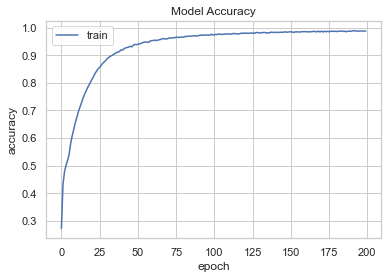

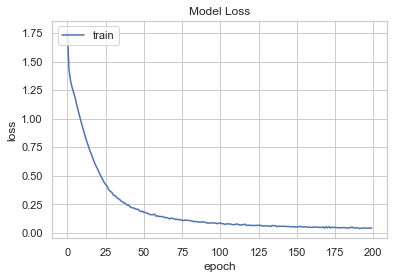

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            460800    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 97.449%


##### Confusion Matrix

15840 is the number of test value in kfold_val / train_test_split


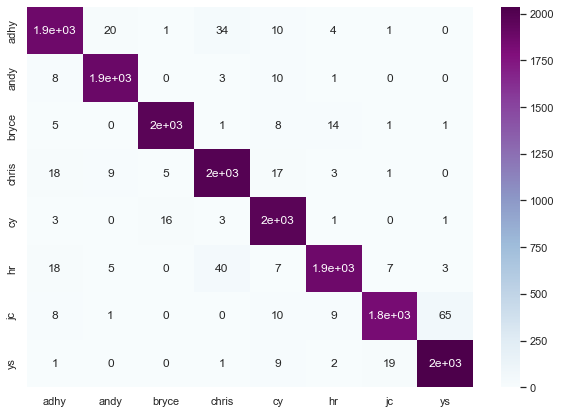

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

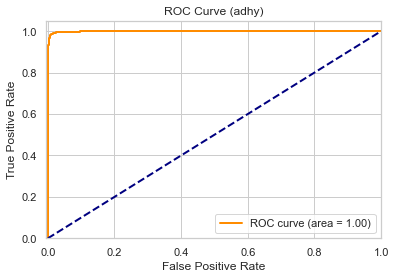

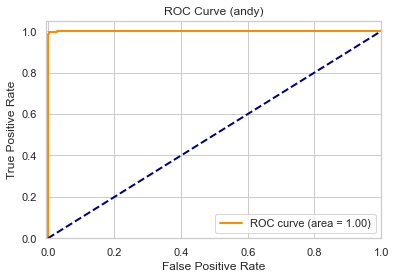

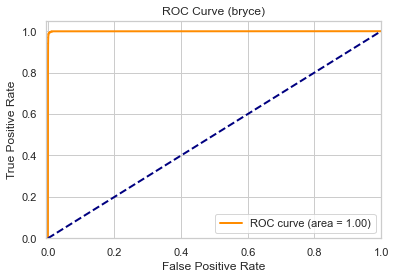

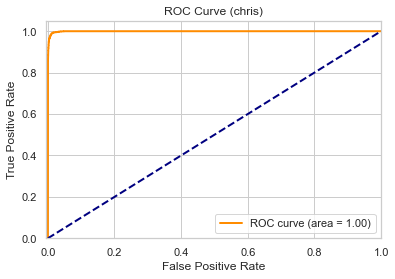

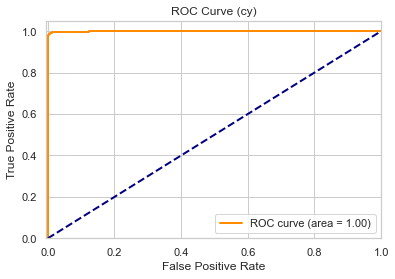

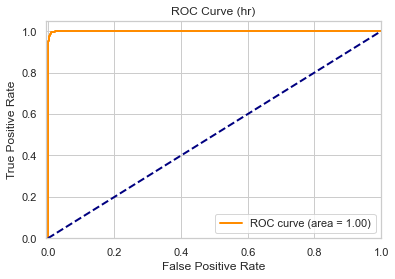

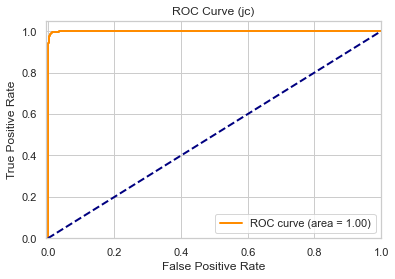

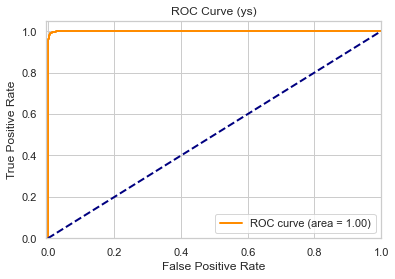

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

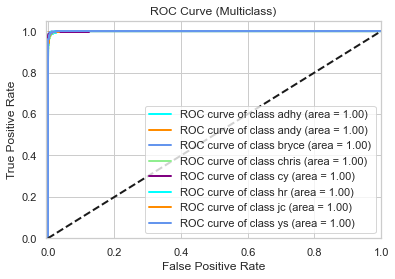

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

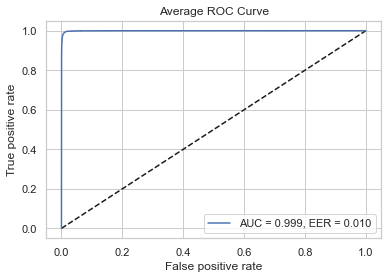

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'andy' 'bryce' 'chris' 'cy' 'hr' 'jc' 'ys']


X | Features | Dataset Shape: (79200, 193)
Y | Classes  | Dataset Shape: (79200, 8)
There are a total of 8 classes.
Epoch 1/200
792/792 [==============================] - 36s 39ms/step - loss: 1.6977 - accuracy: 0.2948
Epoch 2/200
792/792 [==============================] - 30s 38ms/step - loss: 1.4232 - accuracy: 0.4302
Epoch 3/200
792/792 [==============================] - 30s 37ms/step - loss: 1.3124 - accuracy: 0.4841
Epoch 4/200
792/792 [==============================] - 30s 38ms/step - loss: 1.2497 - accuracy: 0.5108
Epoch 5/200
792/792 [==============================] - 30s 38ms/step - loss: 1.1829 - accuracy: 0.5431
Epoch 6/200
792/792 [==============================] - 30s 38ms/step - loss: 1.1042 - accuracy: 0.5855
Epoch 7/200
792/792 [==============================] - 30s 38ms/step - loss: 1.0400 - accuracy: 0.6123
Epoch 8/200
792/792 [==============================] - 39s 49ms/step - l

792/792 [==============================] - 31s 39ms/step - loss: 0.0915 - accuracy: 0.9717
Epoch 78/200
792/792 [==============================] - 31s 39ms/step - loss: 0.0916 - accuracy: 0.9717
Epoch 79/200
792/792 [==============================] - 31s 39ms/step - loss: 0.0895 - accuracy: 0.9715
Epoch 80/200
792/792 [==============================] - 31s 39ms/step - loss: 0.0844 - accuracy: 0.9736
Epoch 81/200
792/792 [==============================] - 30s 38ms/step - loss: 0.0857 - accuracy: 0.9734
Epoch 82/200
792/792 [==============================] - 31s 39ms/step - loss: 0.0858 - accuracy: 0.9732
Epoch 83/200
792/792 [==============================] - 31s 39ms/step - loss: 0.0825 - accuracy: 0.9741
Epoch 84/200
792/792 [==============================] - 31s 39ms/step - loss: 0.0795 - accuracy: 0.9746
Epoch 85/200
792/792 [==============================] - 31s 39ms/step - loss: 0.0829 - accuracy: 0.9745
Epoch 86/200
792/792 [==============================] - 31s 39ms/step - loss:

792/792 [==============================] - 31s 40ms/step - loss: 0.0443 - accuracy: 0.9867
Epoch 156/200
792/792 [==============================] - 31s 40ms/step - loss: 0.0417 - accuracy: 0.9872
Epoch 157/200
792/792 [==============================] - 31s 40ms/step - loss: 0.0442 - accuracy: 0.9865
Epoch 158/200
792/792 [==============================] - 32s 40ms/step - loss: 0.0445 - accuracy: 0.9860
Epoch 159/200
792/792 [==============================] - 41s 52ms/step - loss: 0.0424 - accuracy: 0.9872
Epoch 160/200
792/792 [==============================] - 38s 48ms/step - loss: 0.0414 - accuracy: 0.9878
Epoch 161/200
792/792 [==============================] - 33s 41ms/step - loss: 0.0423 - accuracy: 0.9870
Epoch 162/200
792/792 [==============================] - 32s 41ms/step - loss: 0.0377 - accuracy: 0.9887
Epoch 163/200
792/792 [==============================] - 32s 40ms/step - loss: 0.0397 - accuracy: 0.9883
Epoch 164/200
792/792 [==============================] - 32s 40ms/ste

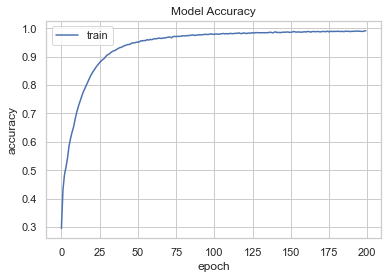

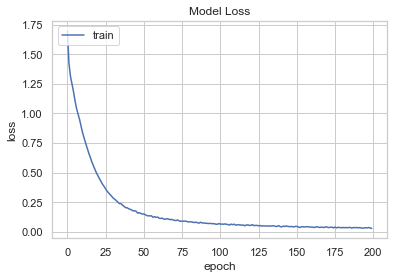

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T4-RF|VAR.1,T4-NG|VAR.1,T4-I|SD.1,T4-PF|SD.1,T4-RF|SD.1,T4-NG|SD.1,T5-I|0+4.1,T5-PF|0+4.1,T5-RF|0+4.1,T5-NG|0+4.1
0,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,9.412329e-03,0.006395,0.062381,0.045333,0.097017,0.079969,0.423147,0.582937,0.551112,0.710902
1,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,3.720000e-07,0.000002,0.006328,0.005632,0.000610,0.001306,0.335316,0.454740,0.408114,0.527538
2,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,3.322198e-01,0.288946,0.525115,0.486267,0.576385,0.537537,1.078749,1.151358,1.166748,1.239357
3,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,3.054200e-04,0.000046,0.034640,0.045301,0.017476,0.006815,0.352062,0.472674,0.439222,0.559834
4,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,1.692164e-02,0.011546,0.107475,0.084844,0.130083,0.107452,0.296025,0.408024,0.384050,0.496050


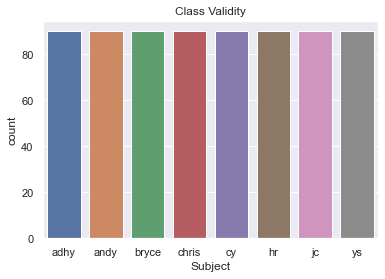

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'andy', 'bryce', 'chris', 'cy', 'hr', 'jc', 'ys']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model: " + str(match_header))

Accuracy of the Model: 265/720 (36.80555555555556%)


In [32]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 06:57:49
